In [8]:


# Load the dataset files

import numpy as np

# Load dataset files
synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
clean_eeg_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"

# Load the numpy arrays
synthetic_eeg_eog = np.load(synthetic_eeg_eog_path, allow_pickle=True).item()  # Dictionary of SNR levels
clean_eeg = np.load(clean_eeg_path)  # Ground truth EEG

# Inspect dataset keys and shapes
print("🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels):", synthetic_eeg_eog.keys())
print("🔹 Clean EEG Shape:", clean_eeg.shape)

# Print shape of each SNR level data
for snr in synthetic_eeg_eog.keys():
    print(f"🔹 SNR Level {snr}: Shape = {synthetic_eeg_eog[snr].shape}")

# Check statistics of clean EEG data
print("🔹 Clean EEG Mean:", np.mean(clean_eeg))
print("🔹 Clean EEG Std Dev:", np.std(clean_eeg))


🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels): dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
🔹 Clean EEG Shape: (3400, 512)
🔹 SNR Level -7: Shape = (3400, 512)
🔹 SNR Level -6: Shape = (3400, 512)
🔹 SNR Level -5: Shape = (3400, 512)
🔹 SNR Level -4: Shape = (3400, 512)
🔹 SNR Level -3: Shape = (3400, 512)
🔹 SNR Level -2: Shape = (3400, 512)
🔹 SNR Level -1: Shape = (3400, 512)
🔹 SNR Level 0: Shape = (3400, 512)
🔹 SNR Level 1: Shape = (3400, 512)
🔹 SNR Level 2: Shape = (3400, 512)
🔹 Clean EEG Mean: -0.16774763156951383
🔹 Clean EEG Std Dev: 231.82429071340553


In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Expand clean EEG dataset (repeat 10 times to match noisy EEG dataset)
X_clean = np.repeat(clean_eeg, 10, axis=0)  # Shape becomes (34,000, 512)

# Step 2: Stack all noisy EEG signals across different SNR levels
X_noisy = np.concatenate([synthetic_eeg_eog[snr] for snr in synthetic_eeg_eog.keys()], axis=0)  # Shape (34,000, 512)

# Step 3: Normalize both clean and noisy EEG signals to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_clean_scaled = scaler.fit_transform(X_clean)  # Normalize clean EEG
X_noisy_scaled = scaler.transform(X_noisy)  # Normalize noisy EEG

# Print dataset details
print(f"✅ Final dataset shapes: Noisy EEG {X_noisy_scaled.shape}, Clean EEG {X_clean_scaled.shape}")
print(f"✅ Clean EEG Mean after Scaling: {np.mean(X_clean_scaled):.4f}, Std Dev: {np.std(X_clean_scaled):.4f}")
print(f"✅ Noisy EEG Mean after Scaling: {np.mean(X_noisy_scaled):.4f}, Std Dev: {np.std(X_noisy_scaled):.4f}")


✅ Final dataset shapes: Noisy EEG (34000, 512), Clean EEG (34000, 512)
✅ Clean EEG Mean after Scaling: -0.0066, Std Dev: 0.2461
✅ Noisy EEG Mean after Scaling: -0.0070, Std Dev: 0.6368


In [26]:
from sklearn.model_selection import train_test_split

# Initialize lists to store train/test sets
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Split each SNR level separately to preserve SNR distribution
for snr in synthetic_eeg_eog.keys():
    noisy_snr = synthetic_eeg_eog[snr]  # Get noisy EEG data for this SNR level
    clean_snr = clean_eeg  # Corresponding clean EEG data

    # Split into 80% Train, 20% Test
    X_train_snr, X_test_snr, y_train_snr, y_test_snr = train_test_split(
        noisy_snr, clean_snr, test_size=0.2, random_state=42
    )

    # Store the results
    X_train_list.append(X_train_snr)
    X_test_list.append(X_test_snr)
    y_train_list.append(y_train_snr)
    y_test_list.append(y_test_snr)

# Stack all train and test data together
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.vstack(y_train_list)
y_test = np.vstack(y_test_list)

# Print dataset sizes
print(f"✅ Final Train Set: Noisy EEG {X_train.shape}, Clean EEG {y_train.shape}")
print(f"✅ Final Test Set: Noisy EEG {X_test.shape}, Clean EEG {y_test.shape}")


✅ Final Train Set: Noisy EEG (27200, 512), Clean EEG (27200, 512)
✅ Final Test Set: Noisy EEG (6800, 512), Clean EEG (6800, 512)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the EEGDiR LSTM Model
class EEGDiR_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.3):
        super(EEGDiR_LSTM, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(hidden_size, 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, input_size)  

        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output the denoised EEG
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGDiR_LSTM().to(device)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"✅ Model is initialized on {device}")


✅ Model is initialized on cuda


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = torch.tensor(noisy_data, dtype=torch.float32).unsqueeze(-1)  # (N, 512, 1)
        self.clean_data = torch.tensor(clean_data, dtype=torch.float32).unsqueeze(-1)  # (N, 512, 1)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]

# Define batch size
batch_size = 512

# Create DataLoader for training and testing
train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders are ready! Training Batch Size: {batch_size}")


✅ DataLoaders are ready! Training Batch Size: 512


In [15]:
import torch.optim.lr_scheduler as lr_scheduler

# Function to train the model with Early Stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3):
    model.train()  # Set model to training mode

    best_loss = float("inf")
    early_stop_counter = 0

    # Learning Rate Scheduler (Reduce LR if loss plateaus)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_test_loss = 0.0

        # Training loop
        for noisy_batch, clean_batch in train_loader:
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for noisy_batch, clean_batch in test_loader:
                noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
                outputs = model(noisy_batch)
                loss = criterion(outputs, clean_batch)
                total_test_loss += loss.item()

        model.train()

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(test_loader)

        # Learning rate scheduling
        scheduler.step(avg_test_loss)

        # Print loss for monitoring
        print(f"🔹 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

        # Check for early stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            early_stop_counter = 0  # Reset counter
            torch.save(model.state_dict(), "best_lstm_model.pth")  # Save best model
            print("✅ Model Improved! Saving...")
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("⏹️ Early Stopping Triggered. Training Stopped!")
            break

    print("✅ Training Completed!")

# Start Training with Early Stopping
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3)


🔹 Epoch [1/50] | Train Loss: 51411.411241 | Test Loss: 45252.111049
✅ Model Improved! Saving...
🔹 Epoch [2/50] | Train Loss: 35550.146231 | Test Loss: 26807.282785
✅ Model Improved! Saving...
🔹 Epoch [3/50] | Train Loss: 26492.008174 | Test Loss: 23651.464565
✅ Model Improved! Saving...
🔹 Epoch [4/50] | Train Loss: 24267.638889 | Test Loss: 22498.225656
✅ Model Improved! Saving...
🔹 Epoch [5/50] | Train Loss: 22837.043620 | Test Loss: 21838.008231
✅ Model Improved! Saving...
🔹 Epoch [6/50] | Train Loss: 22013.109484 | Test Loss: 20714.015625
✅ Model Improved! Saving...
🔹 Epoch [7/50] | Train Loss: 21425.273799 | Test Loss: 20112.595494
✅ Model Improved! Saving...
🔹 Epoch [8/50] | Train Loss: 20898.408673 | Test Loss: 19808.610491
✅ Model Improved! Saving...
🔹 Epoch [9/50] | Train Loss: 20494.453125 | Test Loss: 19848.122210
🔹 Epoch [10/50] | Train Loss: 20226.315936 | Test Loss: 19640.061244
✅ Model Improved! Saving...
🔹 Epoch [11/50] | Train Loss: 20019.910012 | Test Loss: 19218.77378

In [30]:
import numpy as np
from scipy.stats import pearsonr
from scipy.fftpack import fft

# Load the best trained model
model.load_state_dict(torch.load("best_lstm_model.pth"))
model.eval()

# Function to compute RRMSE (Relative Root Mean Square Error)
def compute_rrmse(denoised, clean):
    return np.sqrt(np.mean((denoised - clean) ** 2)) / np.sqrt(np.mean(clean ** 2))

# Function to compute RRMSE in the Spectrum Domain (RRMSE-S)
def compute_rrmse_spectrum(denoised, clean):
    fft_clean = np.abs(fft(clean))  # Compute FFT
    fft_denoised = np.abs(fft(denoised))
    return compute_rrmse(fft_denoised, fft_clean)

# Function to compute Correlation Coefficient (CC)
def compute_cc(denoised, clean):
    return pearsonr(denoised.flatten(), clean.flatten())[0]

# Store results per SNR level
snr_metrics = {}

# Lists to store all values for overall averages
all_rrmse_t = []
all_rrmse_s = []
all_cc = []

# Loop through each SNR level and use pre-split test data
with torch.no_grad():
    for snr_idx, snr in enumerate(synthetic_eeg_eog.keys()):
        print(f"🔹 Evaluating for SNR Level: {snr}")

        # Get the pre-split test data from training
        noisy_snr = X_test_list[snr_idx]  # Use the pre-stored X_test
        clean_snr = y_test_list[snr_idx]  # Use the pre-stored y_test

        # Convert to PyTorch tensors
        noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)
        clean_tensor = torch.tensor(clean_snr, dtype=torch.float32).unsqueeze(-1).to(device)

        # Get model predictions
        denoised_tensor = model(noisy_tensor).cpu().numpy().squeeze()
        clean_snr_np = clean_tensor.cpu().numpy().squeeze()

        # Compute metrics
        rrmse_t_list = [compute_rrmse(denoised_tensor[i], clean_snr_np[i]) for i in range(len(clean_snr_np))]
        rrmse_s_list = [compute_rrmse_spectrum(denoised_tensor[i], clean_snr_np[i]) for i in range(len(clean_snr_np))]
        cc_list = [compute_cc(denoised_tensor[i], clean_snr_np[i]) for i in range(len(clean_snr_np))]

        # Store results for this SNR level
        snr_metrics[snr] = {
            "RRMSE-T": np.mean(rrmse_t_list),
            "RRMSE-S": np.mean(rrmse_s_list),
            "CC": np.mean(cc_list)
        }

        # Append values for overall averaging
        all_rrmse_t.extend(rrmse_t_list)
        all_rrmse_s.extend(rrmse_s_list)
        all_cc.extend(cc_list)

# Compute overall averages
overall_rrmse_t = np.mean(all_rrmse_t)
overall_rrmse_s = np.mean(all_rrmse_s)
overall_cc = np.mean(all_cc)

# Print Results in Table Format
print("\n🔹 **Final Evaluation Per SNR Level:**")
print("-----------------------------------------------------")
print("| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |")
print("-----------------------------------------------------")
for snr in sorted(snr_metrics.keys()):
    print(f"| {snr:3d}  |  {snr_metrics[snr]['RRMSE-T']:.6f}  |  {snr_metrics[snr]['RRMSE-S']:.6f}  |  {snr_metrics[snr]['CC']:.6f}  |")
print("-----------------------------------------------------")

# Print Overall Averages
print("\n🔹 **Overall Averages**:")
print(f"✅ RRMSE-T: {overall_rrmse_t:.6f}, RRMSE-S: {overall_rrmse_s:.6f}, CC: {overall_cc:.6f}")


🔹 Evaluating for SNR Level: -7
🔹 Evaluating for SNR Level: -6
🔹 Evaluating for SNR Level: -5
🔹 Evaluating for SNR Level: -4
🔹 Evaluating for SNR Level: -3
🔹 Evaluating for SNR Level: -2
🔹 Evaluating for SNR Level: -1
🔹 Evaluating for SNR Level: 0
🔹 Evaluating for SNR Level: 1
🔹 Evaluating for SNR Level: 2

🔹 **Final Evaluation Per SNR Level:**
-----------------------------------------------------
| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |
-----------------------------------------------------
|  -7  |  0.735105  |  0.479684  |  0.687532  |
|  -6  |  0.686738  |  0.452608  |  0.728845  |
|  -5  |  0.646646  |  0.429860  |  0.761323  |
|  -4  |  0.611272  |  0.410286  |  0.788634  |
|  -3  |  0.580500  |  0.393555  |  0.811374  |
|  -2  |  0.551269  |  0.377170  |  0.832085  |
|  -1  |  0.523617  |  0.360656  |  0.850851  |
|   0  |  0.497665  |  0.344249  |  0.867558  |
|   1  |  0.474028  |  0.329413  |  0.882210  |
|   2  |  0.448597  |  0.315114  |  0.897351  |
------------------------

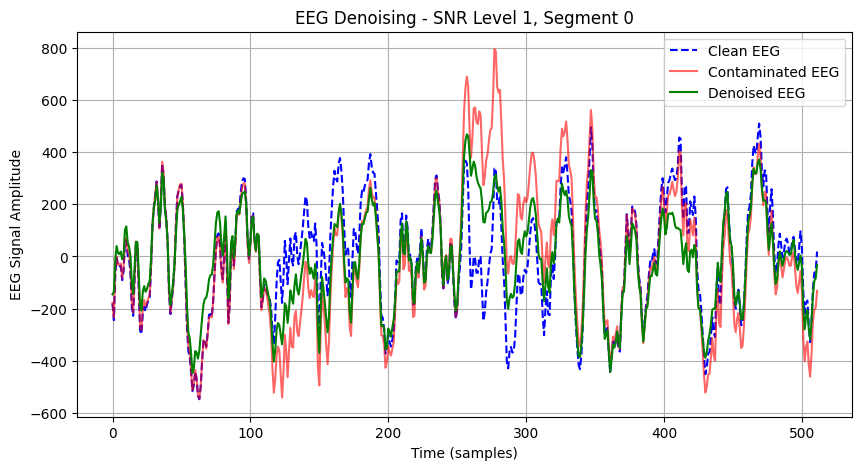

In [33]:
import matplotlib.pyplot as plt

# Select SNR level 1
snr_level = 1
snr_idx = list(synthetic_eeg_eog.keys()).index(snr_level)  # Get index of SNR=1 in test list

# Get test data for SNR=1
noisy_snr = X_test_list[snr_idx]  # Noisy (contaminated) EEG from test set
clean_snr = y_test_list[snr_idx]  # Clean EEG from test set

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy().squeeze()

# Select the 0th segment (first sample)
segment_idx = 0
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR Level {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()
